Problem Statement
Classifying sleep stage using EEG and EOG data

Data Source:- Ask Palak<br>
Data format : 

Reading the data

In [1]:
from pandas import read_csv,unique

In [2]:
raw_data=read_csv('../sleep-stage-classification/dataset/SN001_sleepscoring.txt')
raw_data.head()

,Date,Time,Recording onset,Duration,Annotation,Linked channel
0,01.01.01,23.59.30,0.00,30,Sleep stage W,
1,02.01.01,00.00.00,30.00,30,Sleep stage W,
2,02.01.01,00.00.03.430,33.43,0,Lights off,EEG F4-A1
3,02.01.01,00.00.30,60.00,30,Sleep stage W,
4,02.01.01,00.01.00,90.00,30,Sleep stage W,


In [3]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Recording onset,856.0,12795.072582,7417.375736,0.0,6382.5,12795.0,19207.5,25618.7
Duration,856.0,29.929907,1.449256,0.0,30.0,30.0,30.0,30.0


Exploratory data analysis

In [4]:
#check for count of unique values in different columns 
col_names_rd = raw_data.columns
for col in col_names_rd:
    print(col," ",len(unique(raw_data[col])))

Date   2
Time   856
Recording onset   856
Duration   2
Annotation   7
Linked channel   3


In [5]:
# take a look at columns with low count of unique values
for col in col_names_rd:
    if(len(unique(raw_data[col]))<raw_data.shape[0]/2):
        print(col,"\n",raw_data[col].value_counts(),"\n")

Date 
 02.01.01    855
01.01.01      1
Name: Date, dtype: int64 

Duration 
 30    854
0       2
Name: Duration, dtype: int64 

Annotation 
  Sleep stage N2    430
 Sleep stage W     151
 Sleep stage R     141
 Sleep stage N1    109
 Sleep stage N3     23
 Lights off          1
 Lights on           1
Name: Annotation, dtype: int64 

Linked channel 
                854
 EEG F4-A1       1
 EEG Fpz-Cz      1
Name: Linked channel, dtype: int64 



There are only 3 channels and most of the records have missing Linked channels
Two records have Lights data instead of Sleep stage these two records can be dropped too.
Two records with duration value 0 can be dropped.

<h3> Plotting various plots for data visualization

In [2]:
from matplotlib.pyplot import plot,xticks,show,xlabel,ylabel,title,figure

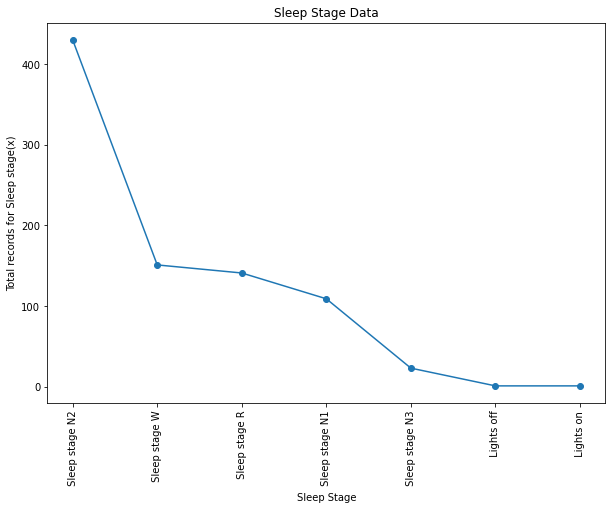

In [7]:
plot_data=raw_data['Annotation'].value_counts()
figure(figsize=(10,7))
title("Sleep Stage Data")
xlabel('Sleep Stage')
ylabel('Total records for Sleep stage(x)')
plot(plot_data,'-o')
xticks(rotation=90)
show()

Convert the .edf data file into csv for smooth processing of data

In [3]:
from mne.io import read_raw_edf
from mne import read_annotations
from numpy import savetxt

Read the edf file, extract channel names

In [9]:
edf_file_data=read_raw_edf('../sleep-stage-classification/dataset/SN001.edf')

Extracting EDF parameters from e:\github\sleep-stage-classification\dataset\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [10]:
headers=','.join(edf_file_data.ch_names) # channel names
savetxt('../sleep-stage-classification/dataset/SN001.csv',edf_file_data.get_data().T,delimiter=',',header=headers)

In [5]:
data_d1=read_csv('../sleep-stage-classification/dataset/SN001.csv')
data_d1.head()

,EEG F4-M1,EEG C4-M1,EEG O2-M1,EEG C3-M2,EMG chin,EOG E1-M2,EOG E2-M2,ECG
0,0.000017,0.000015,0.000038,0.000006,-4.528878e-06,0.000004,-0.000009,0.000074
1,0.000018,0.000016,0.000037,0.000005,1.403830e-06,0.000011,-0.000011,0.000071
2,0.000018,0.000011,0.000024,0.000008,2.319371e-07,0.000022,-0.000010,0.000069
3,0.000011,0.000003,0.000013,0.000006,-2.319371e-07,0.000027,-0.000011,0.000065
4,0.000006,0.000002,0.000018,0.000003,2.868696e-06,0.000026,-0.000015,0.000058


In [17]:
file_a='../sleep-stage-classification/dataset/SN001.edf'
file_b='../sleep-stage-classification/dataset/SN001_sleepscoring.edf'

In [18]:
raw_train=read_raw_edf(file_a)
raw_train=raw_train.drop_channels(['EMG chin','ECG','EEG F4-M1','EEG O2-M1'])
annot_train=read_annotations(file_b)

Extracting EDF parameters from e:\github\sleep-stage-classification\dataset\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [19]:
raw_train.set_annotations(annot_train,emit_warning=False)

<RawEDF | SN001.edf, 4 x 6566400 (25650.0 s), ~9 kB, data not loaded>

Setting up band-pass filter from 0.2 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.20, 35.00 Hz: -6.02, -6.02 dB

Opening raw-browser...


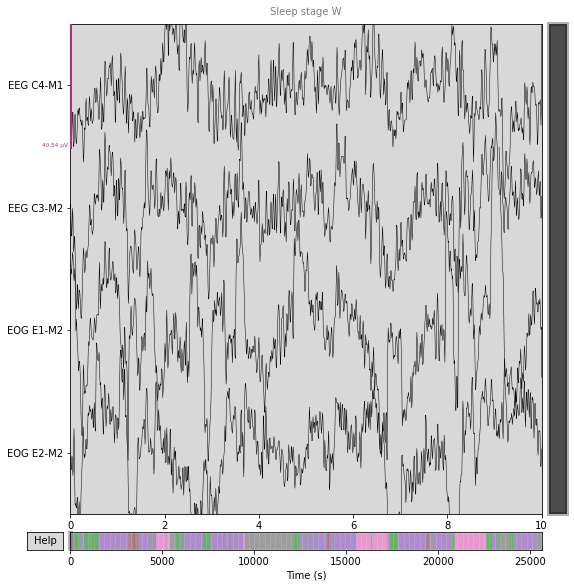

In [20]:

raw_train.plot(duration=10,scalings='auto',event_color='cyan',highpass=0.20,lowpass=35,show_options=True,)#n_channels=)
show()

In [21]:
from mne import events_from_annotations

In [23]:
annotation_desc_2_event_id = {'Sleep stage W':1,'Sleep stage N1':2,'Sleep stage N2':3,'Sleep stage R':5,'Sleep stage N3':4}
events_train,_= events_from_annotations(raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage N3', 'Sleep stage R', 'Sleep stage W']


In [12]:
from mne.viz import plot_events
from matplotlib.pyplot import rcParams

In [24]:
event_ids= {'Sleep stage W':1,'Sleep stage N1':2,'Sleep stage N2':3,'Sleep stage R':5,'Sleep stage N3':4}

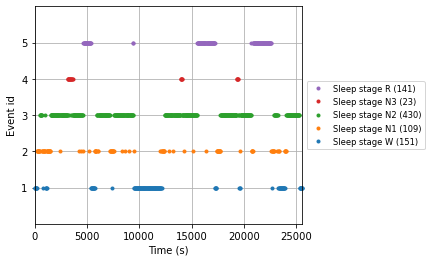

In [27]:
#plot events
plot_events(events_train,event_id=event_ids,sfreq=raw_train.info['sfreq'])
show()
#keep the color-code for further plotting
stage_colors=rcParams['axes.prop_cycle'].by_key()['color']

In [28]:
from mne import Epochs

In [30]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax is included
epochs_train = Epochs(raw=raw_train, events=events_train,event_id=event_ids, tmin=0., tmax=tmax, baseline=None)
epochs_train

Not setting metadata
854 matching events found
No baseline correction applied
0 projection items activated


Number of events,854
Events,Sleep stage N1: 109Sleep stage N2: 430Sleep stage N3: 23Sleep stage R: 141Sleep stage W: 151
Time range,0.000 – 29.996 sec
Baseline,off


Loading data for 854 events and 7680 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\kd372\AppData\Local\Temp\ipykernel_15496\4108629226.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_train.plot_psd(fmin=2,fmax=128,spatial_colors=True)


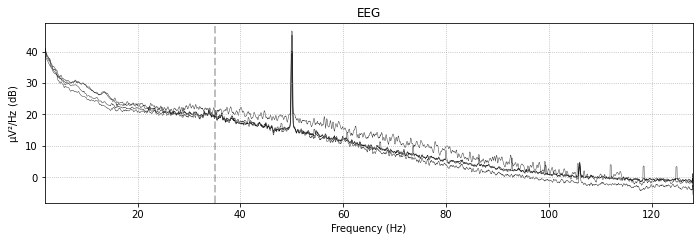

In [37]:
epochs_train.plot_psd(fmin=2,fmax=128,spatial_colors=True)
show()

In [ ]:
import 